In [78]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm import tqdm



In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# 1. Load MNIST from sklearn
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
x = mnist['data'].astype(np.float32) / 255.0
y = mnist['target'].astype(np.int64)

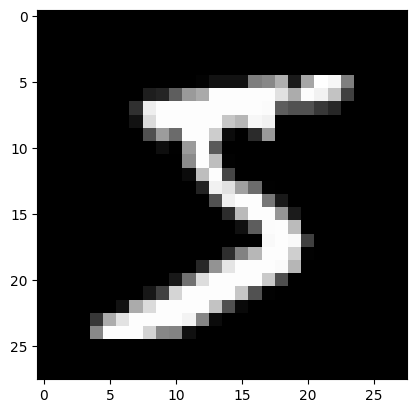

In [15]:
plt.imshow(x[0].reshape(28, 28),cmap='gray')

In [16]:
# 2. Train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [64]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)  
y_test_tensor = torch.tensor(y_test)

In [74]:
train_loader = DataLoader(TensorDataset(x_train_tensor,y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(x_test_tensor,y_test_tensor), batch_size=64, shuffle=True)

In [66]:
# class Autoencoder(nn.Module):
#     def __init__(self,input_dim):
#         super().__init__()
#         self.dropout = nn.Dropout(0.5)
#         # Encoder 
#         self.fc1 = nn.Linear(input_dim,300)
#         # self.dropout1 = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(300, 100)
#         # self.dropout2 = nn.Dropout(0.5)
#         self.fc3 = nn.Linear(100,2)

#         # Decoder 
#         self.fc4 = nn.Linear(2,100)
#         # self.dropout3 = nn.Dropout(0.5)
#         self.fc5 = nn.Linear(100, 300)
#         # self.dropout4 = nn.Dropout(0.5)
#         self.fc6 = nn.Linear(300, input_dim)

#     def forward(self,x):
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.relu(self.fc2(x)))
#         z = self.fc3(x)
#         x = self.dropout(F.relu(self.fc4(z)))
#         x = self.dropout(F.relu(self.fc5(x)))
#         x = torch.sigmoid(self.fc6(x))
#         return x , z 


class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=2, hidden_dims=(300, 100), dropout=0.5):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.dropout = nn.Dropout(dropout)

        # Encoder
        self.enc1 = nn.Linear(input_dim, hidden_dims[0])
        self.enc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.z = nn.Linear(hidden_dims[1], latent_dim)

        # Decoder
        self.dec1 = nn.Linear(latent_dim, hidden_dims[1])
        self.dec2 = nn.Linear(hidden_dims[1], hidden_dims[0])
        self.out = nn.Linear(hidden_dims[0], input_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten if needed
        x = self.dropout(F.relu(self.enc1(x)))
        x = self.dropout(F.relu(self.enc2(x)))
        z = self.z(x)
        x = self.dropout(F.relu(self.dec1(z)))
        x = self.dropout(F.relu(self.dec2(x)))
        x = torch.sigmoid(self.out(x))
        return x, z

In [67]:
config = {
    "input_dim": 784,
    "latent_dim": 2,
    "hidden_dims": (300, 100),
    "dropout": 0.5
}

In [68]:
model = Autoencoder(**config).to(device)
summary(model, input_size=(64, config["input_dim"]), 
        col_names=["input_size", "output_size", "num_params", "kernel_size"],
        col_width=20, depth=3)


Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Kernel Shape
Autoencoder                              [64, 784]            [64, 784]            --                   --
├─Linear: 1-1                            [64, 784]            [64, 300]            235,500              --
├─Dropout: 1-2                           [64, 300]            [64, 300]            --                   --
├─Linear: 1-3                            [64, 300]            [64, 100]            30,100               --
├─Dropout: 1-4                           [64, 100]            [64, 100]            --                   --
├─Linear: 1-5                            [64, 100]            [64, 2]              202                  --
├─Linear: 1-6                            [64, 2]              [64, 100]            300                  --
├─Dropout: 1-7                           [64, 100]            [64, 100]            --                   --
├─Linear: 1-8              

In [76]:
criterion = torch.nn.BCELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [84]:
def train_epoch(model,dataloader,loss_fn,optimizer,device):
    model.train()
    total_loss = 0 

    for inputs , _ in tqdm(dataloader , desc='Training',leave=False): # autoencoder not label
        inputs = inputs.to(device)
        optimizer.zero_grad()

        outputs, _ = model(inputs) # forward pass ทำ forward pass เพื่อให้ model สร้าง output จาก input
        loss = loss_fn(outputs, inputs) # loss compare output vs input
        loss.backward() # calculate gradient 
        optimizer.step() # optimizer = ปรับ weight ตาม gradient 
        total_loss += loss.item() * inputs.size(0)
    return total_loss / len(dataloader.dataset)

def validate_epoch(model, dataloader, loss_fn, device):
    model.eval() # ตั้งโหมด eval (ปิด dropout)
    total_loss = 0
    with torch.no_grad(): # ปิดการคำนวณ gradient ลดการใช้ memory
        for inputs, _ in tqdm(dataloader, desc="Validating", leave=False):
            inputs = inputs.to(device)
            outputs, _ = model(inputs)
            loss = loss_fn(outputs, inputs)
            total_loss += loss.item() * inputs.size(0)
    return total_loss / len(dataloader.dataset)

In [ ]:
train_losses = []
val_losses = []

num_epochs = 5
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_epoch(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:2d}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch  1/5 | Train Loss: 0.1942 | Val Loss: 0.1820


Epoch  2/5 | Train Loss: 0.1940 | Val Loss: 0.1825


Epoch  3/5 | Train Loss: 0.1944 | Val Loss: 0.1823


Epoch  4/5 | Train Loss: 0.1946 | Val Loss: 0.1824


Epoch  5/5 | Train Loss: 0.1941 | Val Loss: 0.1823


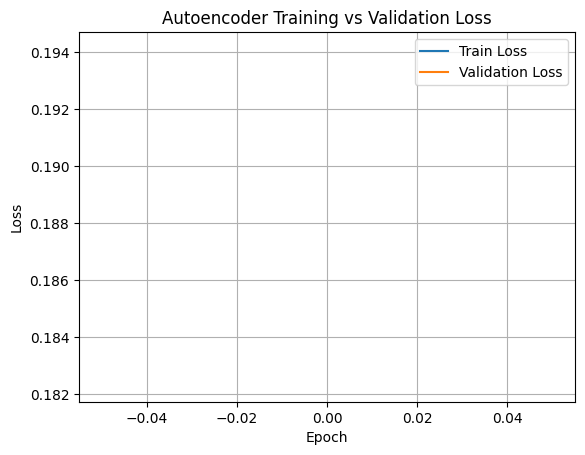

In [92]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()